In [ ]:
!unzip /content/fake_news_images_1999.zip -d /content/fake_news_images_1999


Archive:  /content/fake_news_images_1999.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/fake_news_images_1999.zip or
        /content/fake_news_images_1999.zip.zip, and cannot find /content/fake_news_images_1999.zip.ZIP, period.


In [ ]:
!unzip /content/fake_news_images_1999.zip -d /content/fake_news_images_1999


Archive:  /content/fake_news_images_1999.zip
  inflating: /content/fake_news_images_1999/gossipcop-851296.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-2008641429.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-2755391716.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-841785.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-837368.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-1156925967.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-844795.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-843666.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-843576.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-849387.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-843312.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-1037841505.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-3294462993.jpg  
  inflating: /content/fake_news_images_1999/gossipcop-841493.jpg

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms , models
from transformers import BertTokenizer, BertModel
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F


c:\Users\Ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))
print("CUDA version:", torch.version.cuda)

CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
CUDA version: 12.1


In [ ]:
df = pd.read_csv('Multimodal_FakeNews_Sample_1999_Clean.csv')
df['label'] = df['label'].map({'fake': 0, 'real': 1})


In [ ]:
import re

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, tokenizer, transform):
        self.df = dataframe
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = clean_text(row['text'])

        image_path = os.path.join(self.image_dir, row['image_filename'])
        label = torch.tensor(row['label'])

        text_enc = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        input_ids = text_enc['input_ids'].squeeze(0)
        attention_mask = text_enc['attention_mask'].squeeze(0)

        try:
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)
        except:
            image = torch.zeros(3, 224, 224)

        return input_ids, attention_mask, image, label


In [ ]:
dataset = MultimodalDataset(df, 'fake_news_images_1999', tokenizer, image_transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert = BertModel.from_pretrained('bert-base-uncased').to(device)
bert.eval()

efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet.classifier = nn.Identity()  # Remove final classification head
efficientnet = efficientnet.to(device)
efficientnet.eval()


c:\Users\Ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
text_features = []
image_features = []
labels = []

for input_ids, attention_mask, images, lbls in dataloader:
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    images = images.to(device)

    with torch.no_grad():
        text_out = bert(input_ids=input_ids, attention_mask=attention_mask)
        text_vecs = text_out.last_hidden_state[:, 0, :]

        img_vecs = efficientnet(images)

    fused = torch.cat((2.5*text_vecs, img_vecs), dim=1)

    text_features.append(fused.cpu())
    labels.append(lbls)

X = torch.cat(text_features).numpy()
y = torch.cat(labels).numpy()


In [ ]:


class DeepEarlyFusionNN(nn.Module):
    def __init__(self, text_dim=768, image_dim=1280, hidden_dim=512, dropout1=0.5, dropout2=0.4):
        super(DeepEarlyFusionNN, self).__init__()
        input_dim = text_dim + image_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout1)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout2)

        self.fc3 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        return self.fc3(x)


In [ ]:
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).float()

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(
    X_tensor, y_tensor, test_size=0.3, random_state=42)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
model = DeepEarlyFusionNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(100):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).long().view(-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_x, val_y in test_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_outputs = model(val_x)
            loss = criterion(val_outputs, val_y.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(val_outputs) > 0.5).long().view(-1)
            total += val_y.size(0)
            correct += (predicted == val_y).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    # === Early Stopping ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# === Load the best model before testing/inference ===
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


Epoch 1, Train Loss: 0.6859, Val Loss: 0.6497, Train Acc: 0.5583, Val Acc: 0.6500
Epoch 2, Train Loss: 0.5951, Val Loss: 0.6023, Train Acc: 0.6934, Val Acc: 0.6900
Epoch 3, Train Loss: 0.5369, Val Loss: 0.5785, Train Acc: 0.7477, Val Acc: 0.7167
Epoch 4, Train Loss: 0.5072, Val Loss: 0.5655, Train Acc: 0.7706, Val Acc: 0.7167
Epoch 5, Train Loss: 0.4522, Val Loss: 0.5533, Train Acc: 0.8070, Val Acc: 0.7300
Epoch 6, Train Loss: 0.4157, Val Loss: 0.5455, Train Acc: 0.8277, Val Acc: 0.7283
Epoch 7, Train Loss: 0.3825, Val Loss: 0.5407, Train Acc: 0.8570, Val Acc: 0.7283
Epoch 8, Train Loss: 0.3473, Val Loss: 0.5411, Train Acc: 0.8785, Val Acc: 0.7167
Epoch 9, Train Loss: 0.3089, Val Loss: 0.5414, Train Acc: 0.9042, Val Acc: 0.7267
Epoch 10, Train Loss: 0.2717, Val Loss: 0.5428, Train Acc: 0.9292, Val Acc: 0.7217
Epoch 11, Train Loss: 0.2435, Val Loss: 0.5468, Train Acc: 0.9392, Val Acc: 0.7200
Epoch 12, Train Loss: 0.2249, Val Loss: 0.5549, Train Acc: 0.9435, Val Acc: 0.7183
Early stoppin

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_180\2070692161.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


DeepEarlyFusionNN(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = (outputs > 0.5).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

print(classification_report(all_labels, all_preds, target_names=["fake", "real"]))


              precision    recall  f1-score   support

        fake       0.70      0.85      0.77       322
        real       0.77      0.58      0.66       278

    accuracy                           0.72       600
   macro avg       0.73      0.71      0.71       600
weighted avg       0.73      0.72      0.72       600



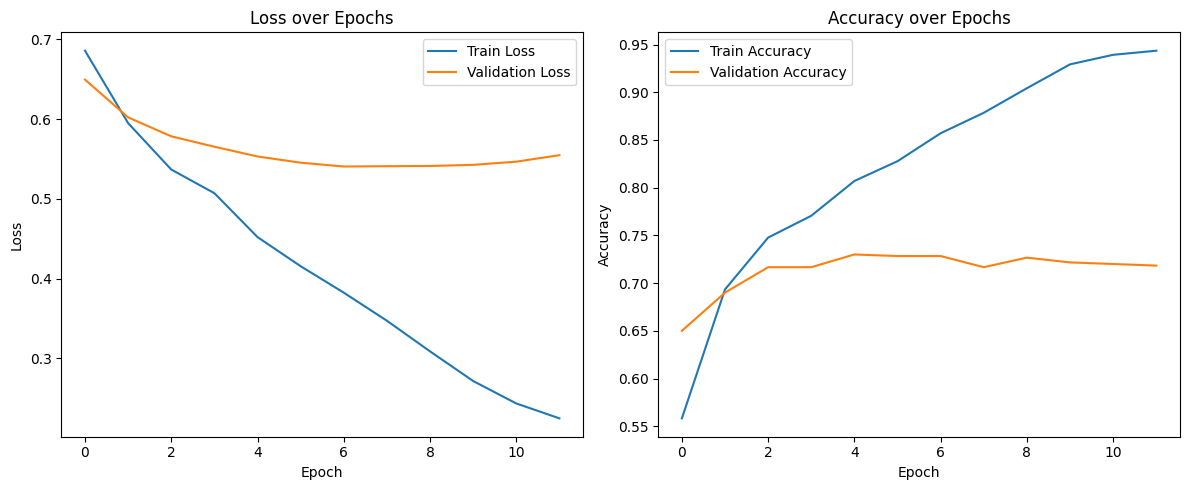

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()